In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from PIL import Image
import os


def get_image_resolution(image_path):
    with Image.open(image_path) as img:
        return img.size


def check_image_resolutions(directory_path):
    files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    for file in files:
        file_path = os.path.join(directory_path, file)
        try:
            resolution = get_image_resolution(file_path)
            print(f"Image: {file}, Resolution: {resolution[0]}x{resolution[1]} pixels")
        except Exception as e:
            print(f"Error processing {file}: {e}")


check_image_resolutions("dataset")

Image: wno_01.jpeg, Resolution: 275x183 pixels
Image: wno_01.jpg, Resolution: 224x224 pixels
Image: wno_02.jpeg, Resolution: 275x183 pixels
Image: wno_02.jpg, Resolution: 800x600 pixels
Image: wno_03.jpeg, Resolution: 225x225 pixels
Image: wno_03.jpg, Resolution: 800x600 pixels
Image: wno_04.jpeg, Resolution: 300x168 pixels
Image: wno_04.jpg, Resolution: 800x600 pixels
Image: wno_05.jpeg, Resolution: 259x194 pixels
Image: wno_05.jpg, Resolution: 800x600 pixels
Image: wno_06.jpeg, Resolution: 275x183 pixels
Image: wno_06.jpg, Resolution: 531x720 pixels
Image: wno_07.jpeg, Resolution: 190x266 pixels
Image: wno_07.jpg, Resolution: 800x687 pixels
Image: wno_08.jpeg, Resolution: 292x172 pixels
Image: wno_08.jpg, Resolution: 531x800 pixels
Image: wno_09.jpeg, Resolution: 268x188 pixels
Image: wno_09.jpg, Resolution: 800x531 pixels
Image: wno_10.jpeg, Resolution: 208x187 pixels
Image: wno_10.jpg, Resolution: 800x591 pixels
Image: wno_11.jpeg, Resolution: 275x183 pixels
Image: wno_11.jpg, Reso

In [3]:
import torch
from torchvision import transforms


def load_images(directory_path, target_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    images = []
    file_names = []
    for file in files:
        file_path = os.path.join(directory_path, file)
        try:
            img = Image.open(file_path)
            resized_img = transform(img)
            images.append(resized_img)

            file_names.append(file)
        except Exception as e:
            print(f"Error processing {file}: {e}")

    # Convert the list of resized images to a PyTorch tensor
    images = torch.stack(images)
    return images, file_names


input_images, file_names = load_images("dataset")
print("Shape of the resized images tensor:", input_images.shape)

Shape of the resized images tensor: torch.Size([104, 3, 224, 224])


## Create embeddings

In [4]:
from torchvision import models


def create_resnet_embeddings(images):
    resnet_model = models.resnet50(pretrained=True)

    # Remove the final classification layer
    resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-1]))

    # Set the model to evaluation mode
    resnet_model.eval()

    # Forward pass to obtain the embeddings
    with torch.no_grad():
        embeddings = resnet_model(images)

    return embeddings.squeeze()


embeddings = create_resnet_embeddings(input_images)
embeddings.shape

/home/ubuntu/tools/minikonda3/envs/hface/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/tools/minikonda3/envs/hface/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([104, 2048])

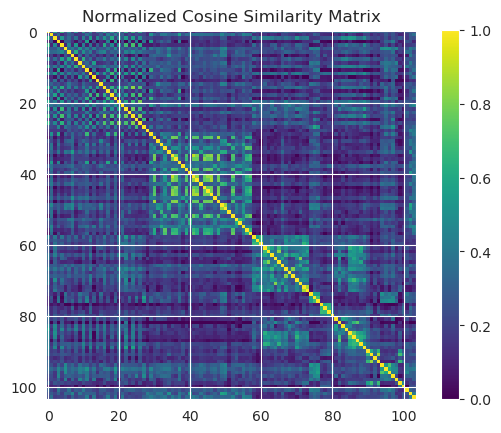

array([ 0, 39, 54, 59, 78, 93])

['wno_01.jpeg',
 'wno_25.jpg',
 'wno_40.jpg',
 'wno_45.jpg',
 'wno_64.jpg',
 'wno_79.jpg']

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import numpy as np

similarity_matrix = cosine_similarity(embeddings)

# Normalize the similarity matrix to the range [0, 1]
scaler = MinMaxScaler()
normalized_similarity_matrix = scaler.fit_transform(similarity_matrix)

# Plot the normalized similarity matrix
plt.imshow(normalized_similarity_matrix, cmap='viridis', interpolation='nearest')
plt.title('Normalized Cosine Similarity Matrix')
plt.colorbar()
plt.show()

# Use DBSCAN (Density-Based Spatial Clustering of Applications with Noise) for outlier detection
eps = 0.01  # Adjust the epsilon value based on your dataset
min_samples = 3  # Adjust the minimum number of samples for a cluster
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
outliers = dbscan.fit_predict(normalized_similarity_matrix)

outlier_indices = np.where(outliers == -1)[0]
display(outlier_indices)
display([file_names[i] for i in outlier_indices])
# # Visualize outliers
# plt.scatter(range(len(outliers)), normalized_similarity_matrix[outliers == -1, 0], color='red', marker='o', label='Outliers')
# plt.scatter(range(len(outliers)), normalized_similarity_matrix[outliers != -1, 0], color='blue', marker='o', label='Inliers')
# plt.title('Outliers Detection')
# plt.xlabel('Image Pair Index')
# plt.ylabel('Cosine Similarity')
# plt.legend()

# plt.show()

## Find outliers using Z-score

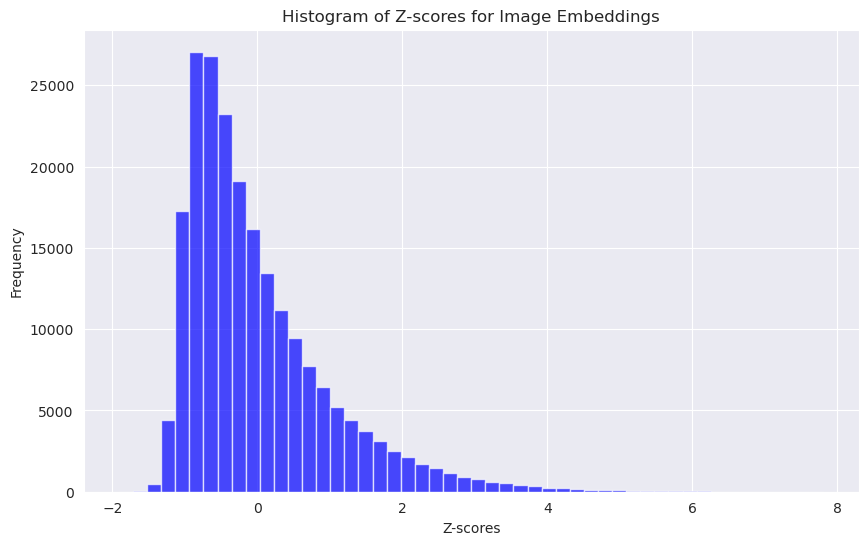

In [56]:
from sklearn.preprocessing import StandardScaler

def compute_z_scores(embeddings):
    embeddings_np = embeddings.numpy()
    
    # Standardize the embeddings using StandardScaler
    scaler = StandardScaler()
    embeddings_standardized = scaler.fit_transform(embeddings_np)
    
    # Calculate Z-scores for each dimension
    z_scores = torch.tensor(embeddings_standardized)
    return z_scores

def visualize_z_scores(z_scores):
    z_scores_flattened = z_scores.view(-1).numpy()

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(z_scores_flattened, bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Z-scores for Image Embeddings')
    plt.xlabel('Z-scores')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

z_scores = compute_z_scores(embeddings)
visualize_z_scores(z_scores)

In [57]:
def detect_outliers_with_z_scores(z_scores, z_score_threshold = 3, ):
    # Identify outliers based on the threshold
    outliers_mask = (z_scores.abs() > z_score_threshold).any(dim=1)
    
    # Extract indices of outlier points
    outlier_indices = torch.nonzero(outliers_mask).squeeze().tolist()
    return outlier_indices

outliers = detect_outliers_with_z_scores(z_scores, 7)
display(outliers)
display([file_names[i] for i in outliers])

[11, 14, 68, 90, 92, 100]

['wno_06.jpg',
 'wno_08.jpeg',
 'wno_54.jpg',
 'wno_76.jpg',
 'wno_78.jpg',
 'wno_86.jpg']

In [62]:
from sklearn.ensemble import IsolationForest


def detect_outliers_isolation_forest(embeddings, contamination=0.05):
    embeddings_np = embeddings.numpy()
    
    isolation_forest = IsolationForest(contamination=contamination, random_state=42)
    outlier_labels = isolation_forest.fit_predict(embeddings_np)
    outlier_indices = torch.nonzero(torch.tensor(outlier_labels) == -1).squeeze().tolist()
    
    return outlier_indices


outliers = detect_outliers_isolation_forest(z_scores, 0.07)
display(outliers)
display([file_names[i] for i in outliers])

[14, 15, 49, 76, 89, 94, 95, 100]

['wno_08.jpeg',
 'wno_08.jpg',
 'wno_35.jpg',
 'wno_62.jpg',
 'wno_75.jpg',
 'wno_80.jpg',
 'wno_81.jpg',
 'wno_86.jpg']

## Visualize embeddings

/tmp/ipykernel_2422/1944477411.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], c=color, alpha=0.5)


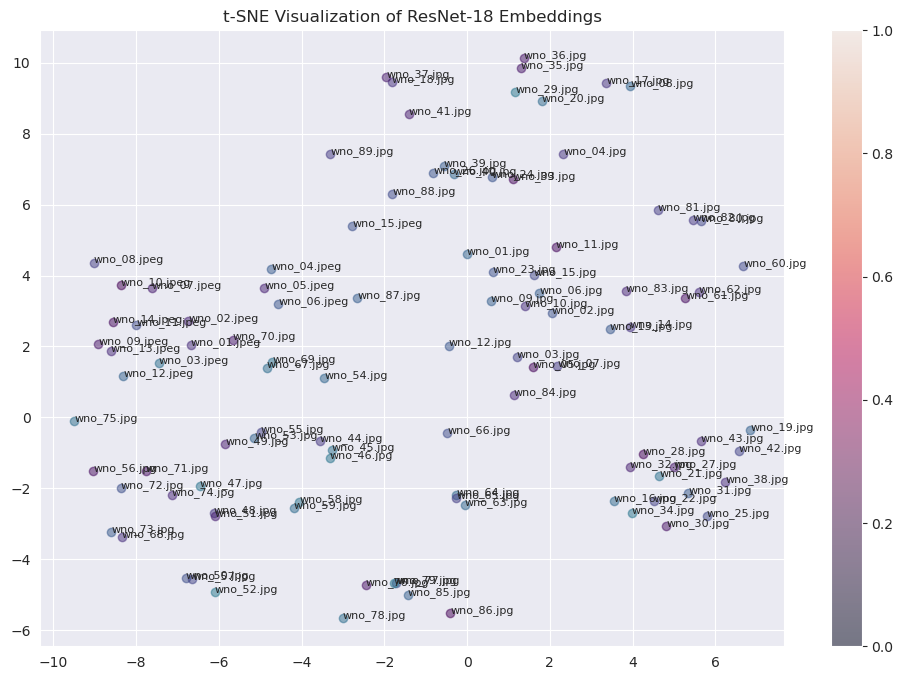

In [30]:
from sklearn.manifold import TSNE


def visualize_embeddings(embeddings, labels):
    unique_labels = list(set(labels))
    label_colors = plt.cm.viridis.colors[:len(unique_labels)]
    label_to_color = dict(zip(unique_labels, label_colors))

    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the embeddings in 2D
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        color = label_to_color[label]
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], c=color, alpha=0.5)
        plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8)

    plt.title('t-SNE Visualization of ResNet-18 Embeddings')
    plt.colorbar()
    plt.show()


labels = range(len(embeddings))
visualize_embeddings(embeddings, file_names)

/home/ubuntu/tools/minikonda3/envs/hface/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ubuntu/tools/minikonda3/envs/hface/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ubuntu/tools/minikonda3/envs/hface/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ubuntu/tools/minikonda3/envs/hface/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

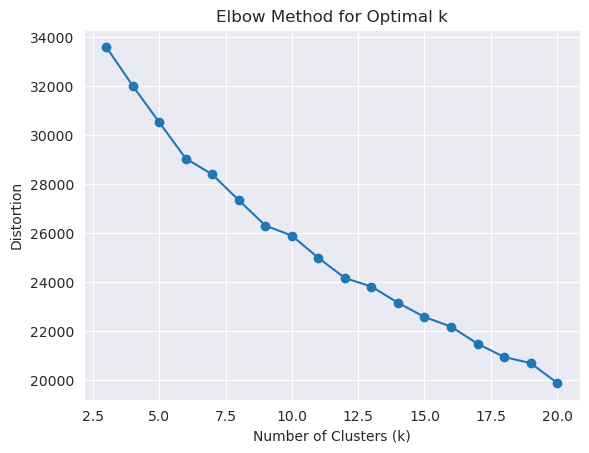

In [31]:
from sklearn.cluster import KMeans


def find_optimal_clusters(embeddings, min_clusters=1, max_clusters=10):
    distortions = []

    for i in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(embeddings)
        distortions.append(kmeans.inertia_)

    # Plot the elbow method
    plt.plot(range(min_clusters, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion')
    plt.show()


find_optimal_clusters(embeddings, min_clusters=3, max_clusters=20)

/home/ubuntu/tools/minikonda3/envs/hface/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


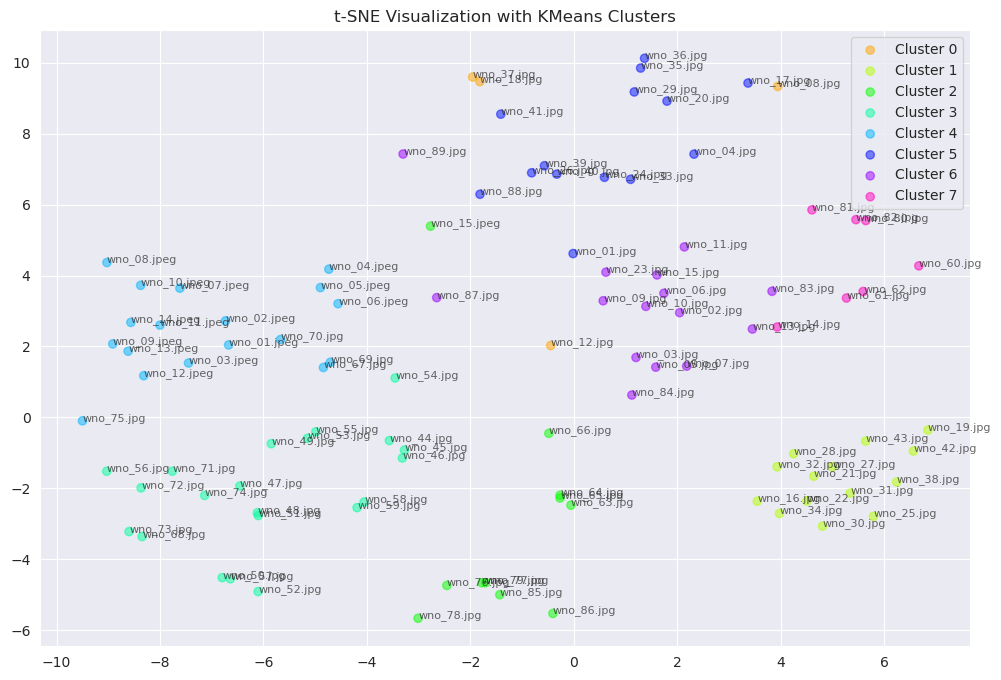

In [35]:
def kmeans_clustering(embeddings, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    return cluster_labels


# Function to visualize all images from each KMeans cluster
def visualize_cluster_images(embeddings, labels, image_file_names, num_clusters=5):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the embeddings in 2D
    plt.figure(figsize=(12, 8))

    color_palette = sns.color_palette("hsv", num_clusters)
    for cluster in range(num_clusters):
        cluster_color = color_palette[cluster]

        # Plot all points in the cluster
        plt.scatter(
            embeddings_2d[labels == cluster, 0], embeddings_2d[labels == cluster, 1],
            c=[cluster_color] * sum(labels == cluster), alpha=0.5,
            marker='o', label=f'Cluster {cluster}')

    # Annotate with file names (smaller font size)
    for i, label in enumerate(image_file_names):
        plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

    plt.title('t-SNE Visualization with KMeans Clusters')
    plt.legend()
    plt.show()


num_clusters = 8
cluster_labels = kmeans_clustering(embeddings, num_clusters)
visualize_cluster_images(embeddings, cluster_labels, file_names, num_clusters=num_clusters)